log 𝑁 = 𝑎 − 𝑏𝑀

1. Magnitude-frequency relation – Gutenberg-Richter Law
2. Compute b-value (relation between magnitude and number of earthquakes) using linear regression


Source of the earthquake data used in this code:
[USGS] https://earthquake.usgs.gov/earthquakes/search/

Parameters used to download the data: \
Location: 39.5 - 41.5 degrees North and 120 - 130 degrees West \
Magnitude: minimum = 2.0 
File format 'csv'



## 1. Earthquake distribution

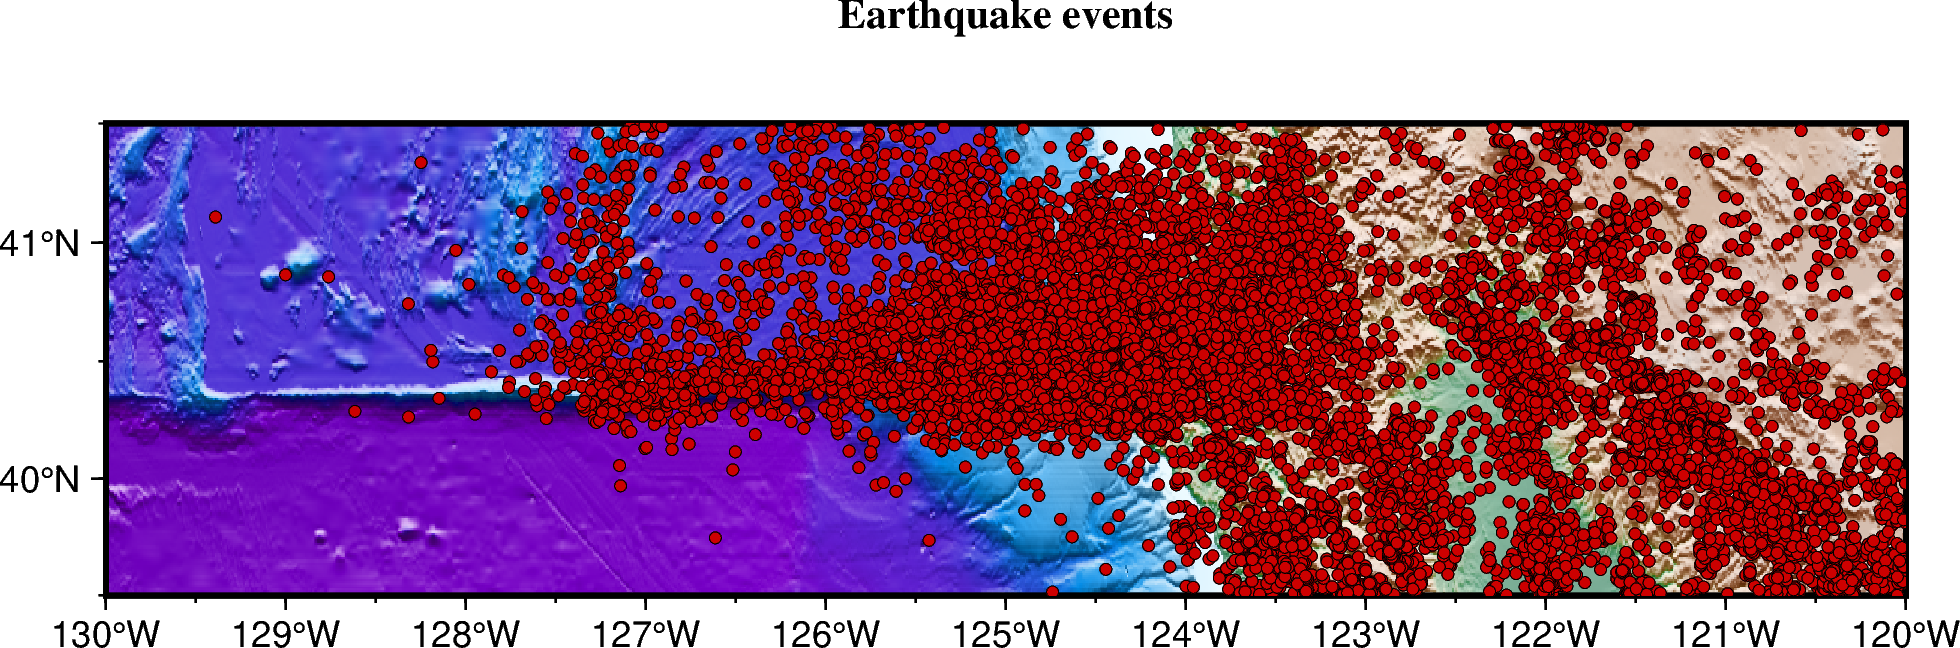

In [81]:
""" 
Purpose of this code is to -
- Plot earthquake events using `pygmt` package
- plot magnitude vs frequency 
- calculate correlatin between magnitude and frequency by linear regression

"""

# import all necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import pygmt
import numpy as np
import os

# create a image directory if it does not exist
if not os.path.exists('png'):
    os.mkdir('png')

# read in the earthquake catalog file
df = pd.read_csv('./all_query-1970_20230901_2-10.csv', header=0, parse_dates=[0, 12])

# Plot the events on map using pygmt
# Define area by geographic coordinates
region = [-130, -120, 39.5, 41.5]

# Import/download relief data with 30s resolution
grid = pygmt.datasets.load_earth_relief(region=region, resolution='30s')

# Apply shade to the grid
shade = pygmt.grdgradient(grid=grid, azimuth=90/270, normalize='t1')

# Make color palette table
pygmt.makecpt(cmap='terra', series=[-7000, 7000])

# Create a figure instance in pygmt
fig = pygmt.Figure()

# Define figure configuration (auto can be selected for most of these options)
pygmt.config(FONT_TITLE='10p,5', MAP_TITLE_OFFSET='auto', MAP_FRAME_TYPE='plain')

# Plot the downloaded grid with color-coding based on the elevation
## projection=M-125/40/6i, cmap='terra' or 'geo', cmap=True uses previously created 
## colormap in `makecpt`.

fig.basemap(region=region, projection="M6i", frame=['f', "+tEarthquake events"])
fig.grdimage(
    grid=grid,
    shading=shade,
    projection='M6i',
    frame=['a1f0.5'],
    cmap='terra'
)

# Plot the events on map
#define lat, lon
x, y = df['longitude'].values, df['latitude'].values
fig.plot(
    x=x,
    y=y,
    #style=circular|0.1|centimeter/in/point
    style='c0.1c',
    #line around the point-shape. pen=1|point/cm/in
    pen='0.1p',
    #filcolor
    fill='red3'
)


# Save the figure in a png file
fig.savefig('png/events_map.png', dpi=300)

# Show figure
fig.show(dpi=300, width='6000')

## 2: Magnitude distribution

Minimum magnitude in this catalog is 2.0, 
and maximum is 7.2. 
Now creating bins.


/var/folders/vr/bxyph_y13z17gzq1r_gst6zw0000gn/T/ipykernel_32914/1438705290.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


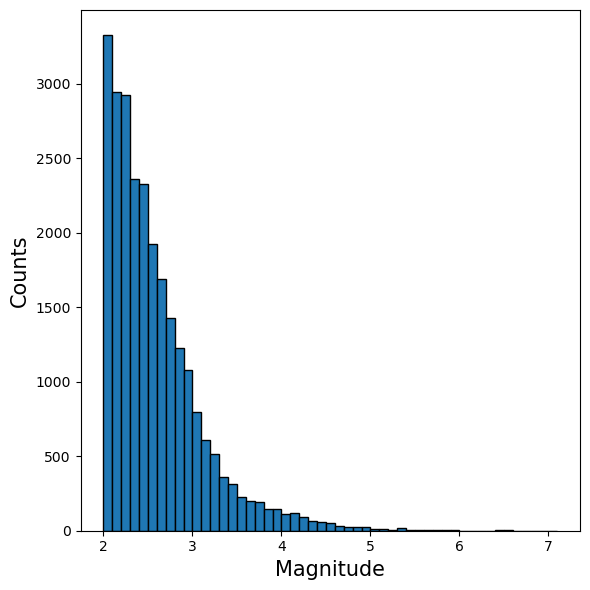

In [82]:
"""
This part of the code will plot magnitude vs frequency/counts
"""

# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import pygmt
import numpy as np
import os

# Extract magnitudes into a numpyarray from all earthquakes catalog
mags = df['mag'].values # this is a numpy array `type(mags)`

# Create bins of magnitude distribution from min to max magnitude
minmag = np.min(mags)
maxmag = np.max(mags)
print(f'Minimum magnitude in this catalog is {minmag}, \nand maximum is {maxmag}. \nNow creating bins.')
bins = np.arange(minmag, maxmag, 0.1)


## Plot magnitude bins in a histogram plot
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)

# create histogram and store outputs in new variables
counts, new_bins, dum = ax.hist(x=mags, bins=bins, edgecolor='black')

# Customize axes
ax.set_xlabel('Magnitude', fontsize=15)
ax.set_ylabel('Counts', fontsize=15)
plt.tight_layout()

# Save and show the figure
fig.savefig('./png/mag_hist.png')
fig.show()




In [83]:
mags

array([5.  , 5.4 , 5.49, ..., 2.09, 2.42, 2.39])

# 3. Plotting earthquake counts vs magnitude:
This Gutenberg-Richter relation describes that there should be 10 times more earthquakes for the 1 lower magnitude, 100 times more earthquakes for 2 lower magnitudes. If there are 50 magnitude-8 earthquakes in a region there should be 500 magnitude-7 earthquakes in the same area within same timeframe.
\
This is described by this relation:
$$log 𝑁 = 𝑎 − 𝑏𝑀$$
where b should be 1.0 ideally.
N, M are the two consecutive magnitudes
`a` is a constant

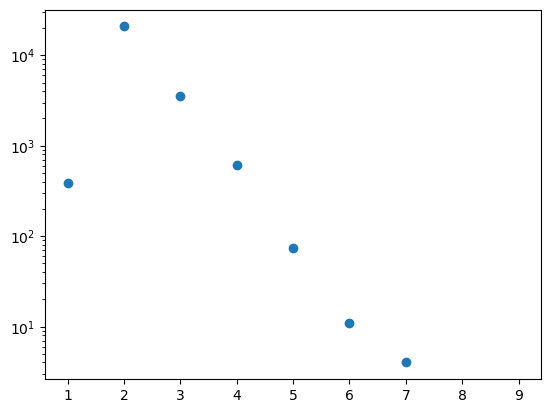

In [84]:
''' this is a non-cumulative plot of magnitude vs frequency '''
# Create bins for magnitude ranges
mag_bins = np.arange(1,11,1)

# Use pd.cut to create bins and then count the occurrences in each bin
mag_counts = pd.cut(df['mag'], bins=mag_bins).value_counts().sort_index()
mag_counts_df = pd.DataFrame(mag_counts).reset_index(drop=True)
mag_counts_df

fig, ax = plt.subplots()

ax.scatter(np.arange(1,10,1), mag_counts_df['count'])
ax.set_yscale('log')

plt.show()

In [85]:
# prepare a mag vs cumulative (higher mag to lower mag) frequency dataframe 
mag_counts_df['mag']=np.arange(2,11,1)

# remove 0 counts rows
mag_counts_df = mag_counts_df[mag_counts_df['count']!=0]

# new column for cumulative count from high magnitude to low
mag_counts_df.sort_values(by='mag', ascending=False, inplace=True)
mag_counts_df['cumulative_count'] = mag_counts_df['count'].cumsum()
mag_counts_df.sort_values(by='mag', ascending=True, inplace=True) #restore the order
mag_counts_df

,count,mag,cumulative_count
0,385,2,25427
1,20845,3,25042
2,3503,4,4197
3,606,5,694
4,73,6,88
5,11,7,15
6,4,8,4


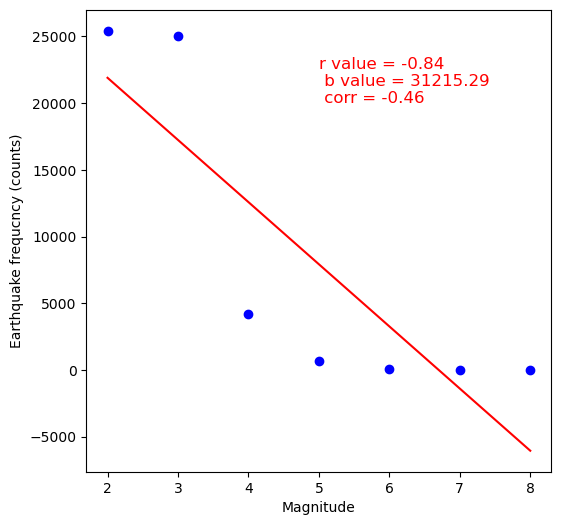

In [88]:
""" calculate b-value using linear regression """
from scipy import stats

# correlation coefficient
corr_matrix = mag_counts_df.corr()
corr = corr_matrix.iloc[0,1]

X = mag_counts_df['mag'] # magnitude bins with earthquake counts

Y = (mag_counts_df['cumulative_count']) # counts of earthquakes in each magnitude bin

slope, intercept, r_value, p_value, std_err = stats.linregress(X, Y)
m = slope
b = intercept

# plot the data with the regression line
fig, ax = plt.subplots(figsize=(6,6))

ax.scatter(X, Y, color='blue')
# ax.scatter(x, y, color='blue')
ax.plot(X, m * X + b, color='red')
# ax.set_yscale('log')
ax.set_xlabel("Magnitude")
ax.set_ylabel("Earthquake frequcncy (counts)")
# ax.set_yscale('log')
plt.text(5,2e4, f'r value = {r_value.round(2)} \n b value = {b.round(2)} \n corr = {corr.round(2)}', fontsize=12, color='red')
plt.show()

# A correlation value of - 0.46 means there is a moderate negative correlation between magnitude of earthquakes and number of earthquakes for that magnitude value. Negative value means frequency decreases with increasing magnitude.
Note that the b value is completely wrong.